# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 60% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.00191609595739
Mean of train-time output:  9.98765668388817
Mean of test-time output:  10.00191609595739
Fraction of train-time output set to zero:  0.700444
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.00191609595739
Mean of train-time output:  10.019857133022683
Mean of test-time output:  10.00191609595739
Fraction of train-time output set to zero:  0.398808
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.00191609595739
Mean of train-time output:  10.010490319141494
Mean of test-time output:  10.00191609595739
Fraction of train-time output set to zero:  0.249388
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445607068760343e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [20]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.3050235295965744
W1 relative error: 7.326834611516573e-07
W2 relative error: 3.2251787701711767e-07
W3 relative error: 5.184013466201528e-08
b1 relative error: 1.506966882059685e-08
b2 relative error: 1.0865138179488165e-08
b3 relative error: 9.400151230752307e-11


Running check with dropout =  0.25
Initial loss:  2.2975909855316043
W1 relative error: 1.167423876074397e-06
W2 relative error: 5.33627586123505e-09
W3 relative error: 5.894960331242089e-09
b1 relative error: 1.4094105868230328e-08
b2 relative error: 7.777307819743917e-10
b3 relative error: 1.273199724574509e-10


Running check with dropout =  0.5
Initial loss:  2.3058955287562277
W1 relative error: 5.782849476256385e-07
W2 relative error: 7.76943118179284e-09
W3 relative error: 3.619411968228497e-08
b1 relative error: 1.8215510679026002e-08
b2 relative error: 1.1095818119562112e-09
b3 relative error: 2.148945481161955e-10




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [10]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

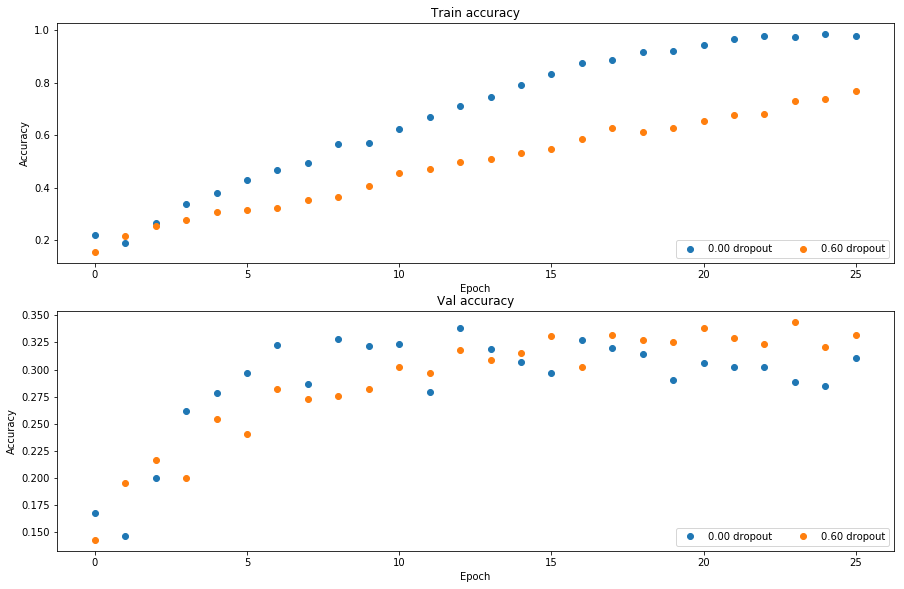

In [11]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Yes, it is performing regularization as it is avoiding overfitting of the data. As can be seen from the plot above that without dropout, the training accuracy is close to 1.0 while the validation accuracy less than that with dropout.

## Final part of the assignment

Get over 60% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [18]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 60% validation accuracy
#   on CIFAR-10.
# ================================================================ #
optimizer = 'adam'
best_model = None

layer_dims = [800, 800, 800,800]
weight_scale = 0.01
learning_rate = 1e-3
lr_decay = 0.95
p= 0.6
reg = 0

model = FullyConnectedNet(layer_dims, dropout=p, reg =reg, weight_scale=weight_scale,
                          use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=50, batch_size=100,
                update_rule=optimizer,
                optim_config={
                  'learning_rate': learning_rate,
                },
                lr_decay=lr_decay,
                verbose=True, print_every=50)
solver.train()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


(Iteration 1 / 24500) loss: 2.360771
(Epoch 0 / 50) train acc: 0.189000; val_acc: 0.167000
(Iteration 51 / 24500) loss: 1.964663
(Iteration 101 / 24500) loss: 1.734092
(Iteration 151 / 24500) loss: 1.668597
(Iteration 201 / 24500) loss: 1.703847
(Iteration 251 / 24500) loss: 1.646514
(Iteration 301 / 24500) loss: 1.619634
(Iteration 351 / 24500) loss: 1.542728
(Iteration 401 / 24500) loss: 1.666457
(Iteration 451 / 24500) loss: 1.707787
(Epoch 1 / 50) train acc: 0.423000; val_acc: 0.478000
(Iteration 501 / 24500) loss: 1.755856
(Iteration 551 / 24500) loss: 1.565179
(Iteration 601 / 24500) loss: 1.716738
(Iteration 651 / 24500) loss: 1.499975
(Iteration 701 / 24500) loss: 1.630720
(Iteration 751 / 24500) loss: 1.354987
(Iteration 801 / 24500) loss: 1.591327
(Iteration 851 / 24500) loss: 1.326774
(Iteration 901 / 24500) loss: 1.487702
(Iteration 951 / 24500) loss: 1.599227
(Epoch 2 / 50) train acc: 0.481000; val_acc: 0.489000
(Iteration 1001 / 24500) loss: 1.503874
(Iteration 1051 / 245

(Iteration 9001 / 24500) loss: 1.111041
(Iteration 9051 / 24500) loss: 0.901177
(Iteration 9101 / 24500) loss: 1.254673
(Iteration 9151 / 24500) loss: 0.836307
(Iteration 9201 / 24500) loss: 0.852985
(Iteration 9251 / 24500) loss: 1.091817
(Iteration 9301 / 24500) loss: 0.799550
(Epoch 19 / 50) train acc: 0.748000; val_acc: 0.586000
(Iteration 9351 / 24500) loss: 0.979999
(Iteration 9401 / 24500) loss: 0.990275
(Iteration 9451 / 24500) loss: 0.733111
(Iteration 9501 / 24500) loss: 0.947873
(Iteration 9551 / 24500) loss: 0.903489
(Iteration 9601 / 24500) loss: 0.997528
(Iteration 9651 / 24500) loss: 0.997864
(Iteration 9701 / 24500) loss: 0.770253
(Iteration 9751 / 24500) loss: 0.871623
(Epoch 20 / 50) train acc: 0.756000; val_acc: 0.577000
(Iteration 9801 / 24500) loss: 0.975837
(Iteration 9851 / 24500) loss: 0.874396
(Iteration 9901 / 24500) loss: 0.856650
(Iteration 9951 / 24500) loss: 0.980018
(Iteration 10001 / 24500) loss: 0.874591
(Iteration 10051 / 24500) loss: 1.070279
(Iterati

(Iteration 17851 / 24500) loss: 0.556075
(Iteration 17901 / 24500) loss: 0.545021
(Iteration 17951 / 24500) loss: 0.639259
(Iteration 18001 / 24500) loss: 0.562932
(Iteration 18051 / 24500) loss: 0.637263
(Iteration 18101 / 24500) loss: 0.596293
(Epoch 37 / 50) train acc: 0.855000; val_acc: 0.587000
(Iteration 18151 / 24500) loss: 0.606157
(Iteration 18201 / 24500) loss: 0.662876
(Iteration 18251 / 24500) loss: 0.643842
(Iteration 18301 / 24500) loss: 0.868404
(Iteration 18351 / 24500) loss: 0.632244
(Iteration 18401 / 24500) loss: 0.763212
(Iteration 18451 / 24500) loss: 0.647028
(Iteration 18501 / 24500) loss: 0.714477
(Iteration 18551 / 24500) loss: 0.518711
(Iteration 18601 / 24500) loss: 0.565850
(Epoch 38 / 50) train acc: 0.859000; val_acc: 0.591000
(Iteration 18651 / 24500) loss: 0.668385
(Iteration 18701 / 24500) loss: 0.797157
(Iteration 18751 / 24500) loss: 0.620015
(Iteration 18801 / 24500) loss: 0.784098
(Iteration 18851 / 24500) loss: 0.606535
(Iteration 18901 / 24500) los

In [19]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Validation set accuracy: {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Validation set accuracy: 0.606
Test set accuracy: 0.603
